In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

 #### ML Flow

In [3]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

# access UI
# mlflow ui --backend-store-uri sqlite:///mlflow.db

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1732646263960, experiment_id='1', last_update_time=1732646263960, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
# read data
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df.head(3)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75


In [5]:
# create 'duration' feature
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
50%         11.400000
95%         33.683333
98%         46.816667
99%         59.825000
max       1438.983333
Name: duration, dtype: float64

In [6]:
# filter duration
df = df[(df.duration >= 1) & (df.duration <= 60)]
df[['duration']].head(3)

,duration
0,11.500000
1,20.866667
2,19.033333


In [7]:
# create numerical/categorical subset
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# cast to string (from int64) to apply dictionary vectorization
df[categorical] = df[categorical].astype(str)

In [8]:
df[categorical + numerical].iloc[:3].to_dict(orient='records')

[{'PULocationID': '236', 'DOLocationID': '239', 'trip_distance': 1.98},
 {'PULocationID': '65', 'DOLocationID': '170', 'trip_distance': 6.54},
 {'PULocationID': '74', 'DOLocationID': '262', 'trip_distance': 3.08}]

In [9]:
# vectorize entire dataset
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [10]:
# create instance Dictionary Vectorized
dv = DictVectorizer()
# perform OHE
X_train = dv.fit_transform(train_dicts)
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 163119 stored elements and shape (54373, 449)>

In [11]:
# list feature names
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',

In [12]:
# create label
target = 'duration'
y_train = df[target]
y_train[:5]

0    11.500000
1    20.866667
2    19.033333
3    11.866667
4    10.983333
Name: duration, dtype: float64

In [13]:
# create linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
# predict label
y_train_hat = lr.predict(X_train)

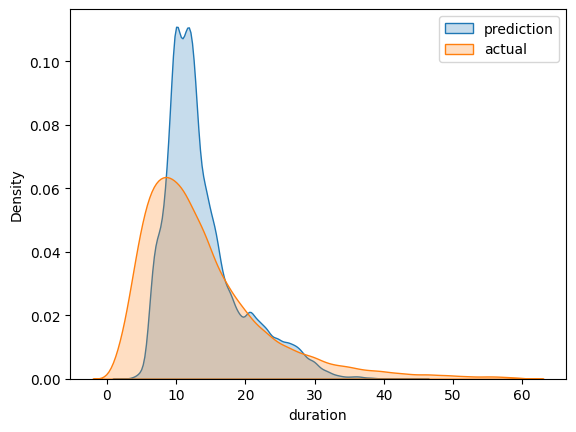

In [15]:
# plot actual VS prediction
plt.figure()
sns.kdeplot(y_train_hat, label='prediction', fill=True)
sns.kdeplot(y_train, label='actual', fill=True)
plt.legend()
plt.show()

In [16]:
# compute RMSE (average minutes of error)
root_mean_squared_error(y_train, y_train_hat)

np.float64(7.1228222122750955)

In [17]:
# create utility function for dataframe reading
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
# january
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
# february
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')
len(df_train), len(df_val)

(54373, 51497)

In [19]:
# combine Pick Up Location and Drop Off Location in one feature
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [20]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()
# fit transform
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
# transform
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

X_train, X_val

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 108746 stored elements and shape (54373, 5093)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 100591 stored elements and shape (51497, 5093)>)

In [21]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [22]:
# fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
# predict on validation
y_val_hat = lr.predict(X_val)
root_mean_squared_error(y_val, y_val_hat)

np.float64(5.995041447869019)

In [27]:
# fit Lasso Regression

# ML Flow log
with mlflow.start_run():

    # run tag: utils for run filtering
    mlflow.set_tag('developer', 'leonardo')

    # useful parameters
    mlflow.log_param('train-data-path', 'green_tripdata_2024-01.parquet')
    mlflow.log_param('val-data-path', 'green_tripdata_2024-02.parquet')
    alpha = 0.01
    mlflow.log_param('alpha', alpha)
    
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    # predict on validation
    y_val_hat = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_val_hat)

    # metrics
    mlflow.log_metric('rmse', rmse)

In [24]:
# fit Ridge Regression
lr = Ridge()
lr.fit(X_train, y_train)
# predict on validation
y_val_hat = lr.predict(X_val)
root_mean_squared_error(y_val, y_val_hat)

np.float64(5.980948972923878)

In [25]:
# save model
with open('models/taxi_ridge_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)